In [1]:
%pylab inline
import numpy as np
import theano
import theano.tensor as T
from theano import pp



Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
X = T.dmatrix('X')
index = T.imatrix('index1')
alpha = T.dscalar('alpha')
observations = T.dmatrix('observations')
obsvalid = T.dmatrix('obsvalid')

translation_vectors = X.reshape((X.shape[0], 1, -1)) - X.reshape((1, X.shape[0], -1))
euclidean_dist2 = ((translation_vectors) ** 2).sum(2) 
term1 = 1.0 + euclidean_dist2[index[:, 0], index[:, 1]]/ alpha
term2 = 1.0 + euclidean_dist2[index[:, 0], index[:, 2]] / alpha
a = -(alpha + 1)/2.0

p =  -T.sum(a * T.log(term1) - T.log(term1**a + term2**a))

f1 = theano.function([X, alpha], euclidean_dist2, 
                                 on_unused_input='ignore')
f2 = theano.function([X, index, alpha], p, 
                                 on_unused_input='ignore')

pgrad = T.grad(p, X)
f3 = theano.function([X, index, alpha], pgrad )

In [3]:
D = 2 
N = 5
Xv = np.arange(D*N).reshape(N, D)

In [4]:
f1(Xv, 1.0)

array([[   0.,    8.,   32.,   72.,  128.],
       [   8.,    0.,    8.,   32.,   72.],
       [  32.,    8.,    0.,    8.,   32.],
       [  72.,   32.,    8.,    0.,    8.],
       [ 128.,   72.,   32.,    8.,    0.]])

In [6]:
import synthetic
reload(synthetic)
import losses

xtrue.shape= (200, 2)
(200, 200)
(200, 200)
21


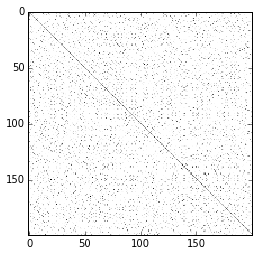

In [7]:
lossobj = losses.Poisson(10.0)
g = synthetic.latent_space_ring(200, 2, gauss_size=0.2, lossobj=lossobj)
adj = synthetic.get_adj_mat(g)
print np.max(adj)
ndf = synthetic.get_nodes_to_df(g)
pylab.imshow(adj, interpolation='nearest', cmap=pylab.cm.Greys)

In [8]:
np.sum(adj == 0) / (200.*200)

0.84477500000000005

/Users/jonas/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


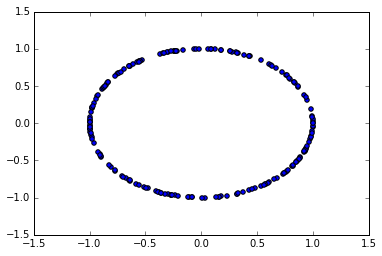

In [9]:
a = ndf.pos
pos = np.vstack(a)
pylab.scatter(pos[:, 0], pos[:, 1])

In [10]:
def get_random_triplets(N, adj):
    triplets = []
    while len(triplets ) < N:
        idx = np.random.randint(0, adj.shape[0], 3)
        if adj[idx[0], idx[1]] > adj[idx[0], idx[2]]:
            triplets.append(idx)
    return triplets
triplets = get_random_triplets(10000, adj)


0 6921.35660045
100 3662.24447706
0 6789.59652754
100 3140.06931093
0 6857.72624583
100 3206.58987819
0 6451.11466375
100 2677.79228187
0 6102.21358764
100 2024.41766453
0 6435.34763647
100 1483.51952515
0 8831.24641074
100 799.585670572


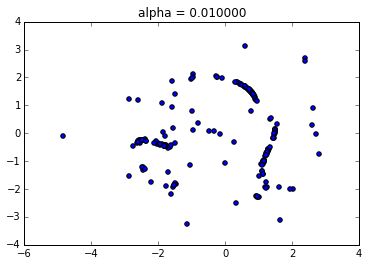

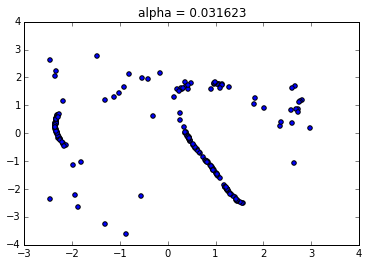

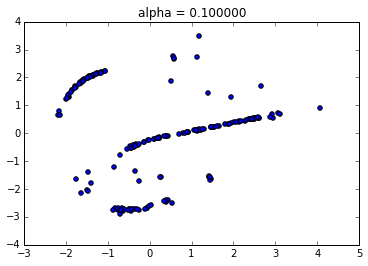

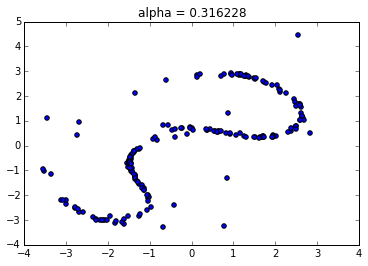

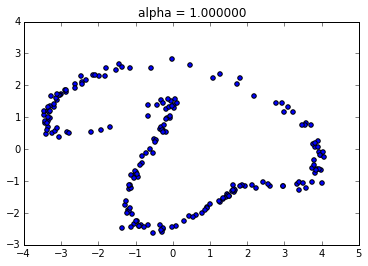

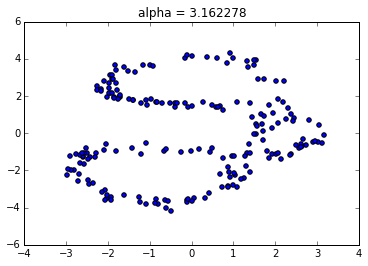

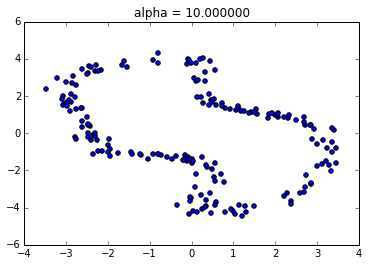

In [12]:
N = adj.shape[0]
ITERS = 200
gamma = 0.1
np.random.seed(0)
for alpha in np.logspace(-2, 1, 7):
    x =  np.random.normal(0, 1, (N, 2))

    #alpha = 0.1
    for i in range(ITERS):
        x = x - gamma/(i+1) * f3(x, triplets, alpha)
        if i % 100 == 0:
            print i, f2(x, triplets, alpha)
    pylab.figure()
    pylab.scatter(x[:, 0], x[:, 1])
    pylab.title('alpha = %f' % alpha)
    

In [78]:

class STE(object):
    """
    Stochastic triplet embedding
    """
    def __init__(self, alpha):
        self.alpha = alpha


    def cost(self):
        def log_likelihood_func(obs, kernmat):
            alpha = self.alpha
            term1 = 1.0 + kernmat[obs[:, 0], obs[:, 1]]/ alpha
            term2 = 1.0 + kernmat[obs[:, 0], obs[:, 2]] / alpha
            a = -(alpha + 1)/2.0

            p = - (a * T.log(term1) - T.log(term1**a + term2**a))
            return p

        return log_likelihood_func

    def obs_forward(self, x):
        """
        go from kernel val to observations
        """
        raise NotImplementedError()
        

In [73]:
def run_sgd_full(kernel_func, log_likelihood_func,
                 xinit, theta_init, obs, obs_valid, alpha = 0.5, 
                 iters = 10000, seed = None, use_adagrad=False, 
                 logfunc = None, batch_size=None, partition_batch=False, 
                 theta_inference = True, theta_alpha= None, 
                 verbose=True, verbose_iter = 100):
    """
    SGD on full model, computing the gradient on all params. 

    code maximizes the log likelihood  

    kern_func : a function which returns a theano expression in X

    log_likelihood_func : function of observations x kernel, 
    such as the log likelihood of the poisson

    
    """
    
    N, DIM = xinit.shape

    # now the actual distance function

    X = T.dmatrix('X')
    theta = T.dvector('theta')
    observations = T.matrix('observations', dtype=obs.dtype)
    obsvalid = T.dmatrix('obsvalid')

    kern = kernel_func(X, theta)

    observation_expression = log_likelihood_func(observations, 
                                                 kern)
    obsmodel_elem = observation_expression  # * obsvalid
    obsmodel = T.sum(obsmodel_elem)
    obsmodel_f = theano.function([X, theta, observations, obsvalid], obsmodel, 
                                 on_unused_input='ignore')

    obsmodel_grad = T.grad(obsmodel, X)
    obsmodel_grad_f = theano.function([X, theta, observations, obsvalid], 
                                      obsmodel_grad, 
                                      on_unused_input='ignore')
    
    return obsmodel_f, obsmodel_grad_f

N = adj.shape[0]
ITERS = 1000
gamma = 0.1

obs = np.array(triplets, dtype=np.int32)

x =  np.random.normal(0, 0.1, (N, 2))
alpha = 0.1
f2(x, obs, alpha)



array(6928.341333129009)

In [76]:


obsvalid = np.ones((N, 2))
    
for alpha in np.logspace(-2, 1.5, 7):
    x =  np.random.normal(0, 0.1, (N, 2))

    ste = STEbase()
    
    kern_func = studentt() # alpha)
    obs = np.array(triplets, dtype=np.int32)
    print alpha

    f, gradf = run_sgd_full(kern_func, ste.cost(), x.copy(), [alpha],  obs, obsvalid)

    for i in range(ITERS):
        # X, theta, observations, obsvalid
        g =  gradf(x, [alpha], obs, obsvalid)
        x = x + gamma/(i+1) * g
        if i % 100 == 0:
            print i, f(x, [], obs, obsvalid), f2(x, obs, alpha)
    pylab.figure()
    pylab.scatter(x[:, 0], x[:, 1])
    pylab.title('alpha = %f' % alpha)

0.01
0

IndexError: index out of bounds
Apply node that caused the error: Subtensor{int64}(theta, Constant{0})
Inputs types: [TensorType(float64, vector), Scalar(int64)]
Inputs shapes: [(0,), ()]
Inputs strides: [(8,), ()]
Inputs values: [array([], dtype=float64), 0]

Backtrace when the node is created:
  File "<ipython-input-72-2014d899ea05>", line 30, in kern_func
    alpha = theta[0]

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

-2.0
0 obj= -12831.3923117 ||grad||= 316.491108149 ||x||= 158.296505617 0.00
-1.41666666667
0 obj= -13701.1796225 ||grad||= 213.359215385 ||x||= 106.566552642 0.00
-0.833333333333
0 obj= -14305.842341 ||grad||= 126.569922241 ||x||= 63.3901940954 0.00
-0.25
0 obj= -13674.6255533 ||grad||= 113.395576422 ||x||= 56.5842861329 0.00
0.333333333333
0 obj= -15778.289132 ||grad||= 81.9635802312 ||x||= 40.7966177984 0.00
0.916666666667
0 obj= -15485.5977537 ||grad||= 61.7243541617 ||x||= 30.8701932969 0.00
1.5
0 obj= -13663.2967116 ||grad||= 69.5122198287 ||x||= 35.0663760552 0.00


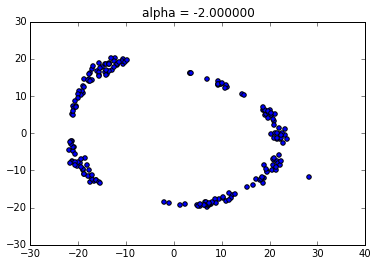

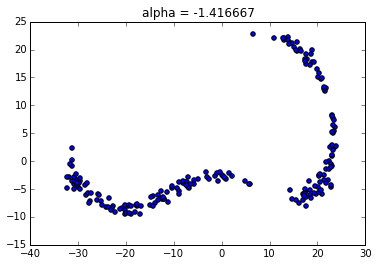

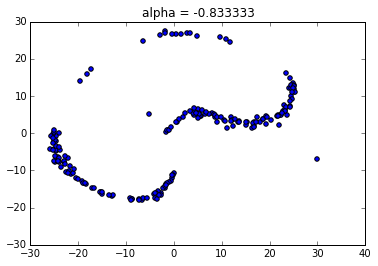

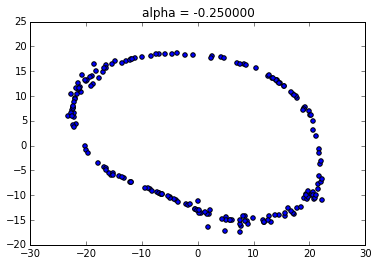

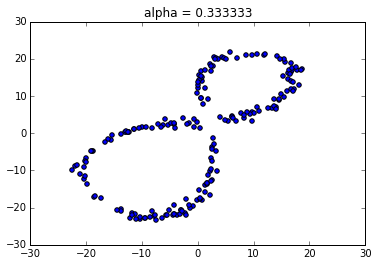

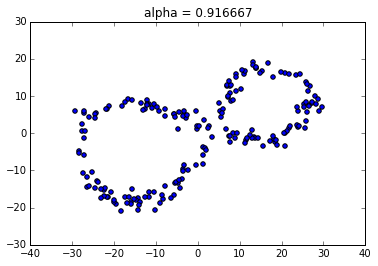

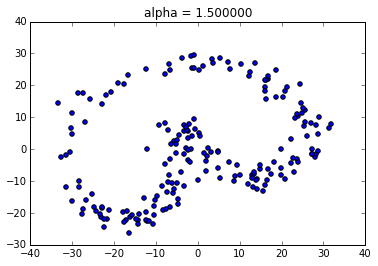

In [86]:
import triplet




obsvalid = np.ones((2, len(obs)))
    
for alpha in np.linspace(-2, 1.5, 7):
    x =  np.random.normal(0, 0.1, (N, 2))

    ste = STEbase()
    
    kern_func = studentt()
    obs = np.array(triplets, dtype=np.int32)
    print alpha

    
    ret = triplet.run_sgd_full(kern_func, ste.cost(), x.copy(), [alpha],  obs, 
                        obsvalid,  theta_inference=False, iters=100)

    x = ret['x_est']
    pylab.figure()
    pylab.scatter(x[:, 0], x[:, 1])
    pylab.title('alpha = %f' % alpha)

1.5
0 obj= -13830.5137345 ||grad||= 49.0532913705 ||x||= 2.05037271254 0.00
100 obj= -619.104766052 ||grad||= 18.3680136541 ||x||= 62.3990267591 0.01
200 obj= -418.078664434 ||grad||= 11.1587871656 ||x||= 75.0659097604 0.03
300 obj= -326.625231273 ||grad||= 8.24422550981 ||x||= 83.8116797613 0.04
400 obj= -271.622763958 ||grad||= 6.74401768243 ||x||= 90.68614318 0.05
500 obj= -232.660554579 ||grad||= 5.75853348475 ||x||= 96.4629881428 0.07
600 obj= -203.90017055 ||grad||= 5.00207956484 ||x||= 101.475609969 0.08
700 obj= -181.7235705 ||grad||= 4.44682103343 ||x||= 105.892486251 0.09
800 obj= -163.32887612 ||grad||= 4.18331086809 ||x||= 109.842448511 0.11
900 obj= -147.943560646 ||grad||= 3.68220288194 ||x||= 113.436333042 0.12
1000 obj= -135.59691005 ||grad||= 3.36043901205 ||x||= 116.731437423 0.13
1100 obj= -125.195552487 ||grad||= 3.09522678926 ||x||= 119.773437427 0.14
1200 obj= -116.335908302 ||grad||= 2.86295682914 ||x||= 122.596786789 0.16
1300 obj= -108.717486521 ||grad||= 2.662

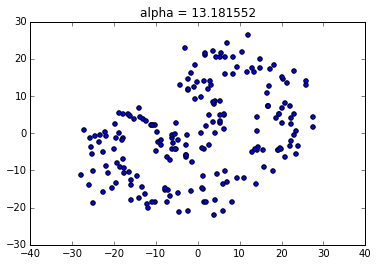

In [100]:




obsvalid = np.ones((2, len(obs)))
    
x =  np.random.normal(0, 0.1, (N, 2))

ste = STEbase()

kern_func = studentt()
obs = np.array(triplets, dtype=np.int32)
print alpha


ret = run_sgd_full(kern_func, ste.cost(), x.copy(), [4.0],  obs, 
                    obsvalid, theta_inference=True, alpha=1e-2, 
                   iters=100000, verbose_iter = 100)

x = ret['x_est']
pylab.figure()
pylab.scatter(x[:, 0], x[:, 1])
pylab.title('alpha = %f' % ret['theta_est'])